In [ ]:
import geopandas as gpd

path = "G:\Maestría\Tesis\Repo\data\data_out\gridded_predictions\effnet_v2S_lr0.0001_size128_y2013-2018-2022_stack1-4"
for year in [2013, 2018, 2022]:
    gdf = gpd.read_parquet(rf"{path}\effnet_v2S_lr0.0001_size128_y2013-2018-2022_stack1-4_141_predictions_{year}.parquet") 
    gdf = gdf[["id", "bounds_geom", "link", "real_value", "prediction", "prediction_error"]].rename(columns={"bounds_geom": "geometry", "prediction_error": "error"})
    gdf.set_geometry("geometry", inplace=True)
    gdf.to_file(rf"{path}\income_estimates_{year}.shp")

        

In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
path = "G:\Maestría\Tesis\Repo\data\data_out\gridded_predictions\effnet_v2S_lr0.0001_size128_y2013-2018-2022_stack1-4"
decile_bounds = {"1": {"limite_inferior": np.NINF, "limite_superior": -1.30130044}, "2": {"limite_inferior": -1.30130044, "limite_superior": -1.02402992}, "3": {"limite_inferior": -1.02402992, "limite_superior": -0.71185961}, "4": {"limite_inferior": -0.71185961, "limite_superior": -0.37386698}, "5": {"limite_inferior": -0.37386698, "limite_superior": -0.01092579}, "6": {"limite_inferior": -0.01092579, "limite_superior": 0.32984989}, "7": {"limite_inferior": 0.32984989, "limite_superior": 0.69376265}, "8": {"limite_inferior": 0.69376265, "limite_superior": 1.02693837}, "9": {"limite_inferior": 1.02693837, "limite_superior": 1.36151268}, "10": {"limite_inferior": 1.36151268, "limite_superior": np.inf}, "11":{"limite_inferior": np.inf}}
gdfs = []
for year in [2013, 2018, 2022]:
    gdf = gpd.read_parquet(rf"{path}\effnet_v2S_lr0.0001_size128_y2013-2018-2022_stack1-4_141_predictions_{year}.parquet") 
    gdf = gdf[["id", "bounds_geom", "link", "real_value", "prediction", "prediction_error"]].rename(columns={"bounds_geom": "geometry", "prediction_error": "error"})
    gdf.set_geometry("geometry", inplace=True)
    gdf["prediction_d"] = pd.cut(gdf["prediction"], bins=[decile_bounds[str(i)]["limite_inferior"] for i in range(1, 12)], labels=[i for i in range(1, 11)])
    gdf["real_value_d"] = pd.cut(gdf["real_value"], bins=[decile_bounds[str(i)]["limite_inferior"] for i in range(1, 12)], labels=[i for i in range(1, 11)])
    gdfs += [gdf]

In [ ]:
# import numpy as np
# gdf["geometry"] = gdf.centroid

# # Extract the x and y coordinates
# x_coords = gdf.geometry.x
# y_coords = gdf.geometry.y

# # Calculate the unique differences in x and y directions
# x_diff = np.unique(np.diff(np.sort(x_coords)))
# y_diff = np.unique(np.diff(np.sort(y_coords)))

# # Assuming a regular grid, the resolution is the smallest non-zero difference
# resolution_x = np.min(x_diff[x_diff > 0])
# resolution_y = np.min(y_diff[y_diff > 0])

# print(f"Resolution: ({resolution_x}, {resolution_y})")

# resolution_x = np.max(x_diff[x_diff > 0])
# resolution_y = np.max(y_diff[y_diff > 0])

# print(f"Resolution: ({resolution_x}, {resolution_y})")


In [10]:
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial

grids = []
for i, year in enumerate([2013, 2018, 2022]):
    year_gdf = gdfs[i]
    year_gdf["geometry"] = year_gdf.centroid
    year_gdf["prediction_d"] = year_gdf["prediction_d"].astype(float)
    year_gdf = year_gdf[["geometry", "prediction_d", "prediction"]]
    if i == 0:
        geo_grid = make_geocube(
            vector_data=year_gdf,
            measurements=['prediction', 'prediction_d'],
            resolution=(-0.00059, 0.00059),
            rasterize_function=rasterize_points_griddata,
        )
    else:
        geo_grid = make_geocube(
            vector_data=year_gdf,
            measurements=['prediction', 'prediction_d'],
            like=grids[0],
            rasterize_function=rasterize_points_griddata
        )
    polygon  = year_gdf.dissolve()
    geo_grid = geo_grid.rio.clip(polygon.geometry, gdf.crs)
    geo_grid = geo_grid.assign_coords(year=year)
    grids += [geo_grid]

C:\Users\ofici\AppData\Local\Temp\ipykernel_19768\35726642.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  year_gdf["geometry"] = year_gdf.centroid
C:\Users\ofici\AppData\Local\Temp\ipykernel_19768\35726642.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  year_gdf["geometry"] = year_gdf.centroid
C:\Users\ofici\AppData\Local\Temp\ipykernel_19768\35726642.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  year_gdf["geometry"] = year_gdf.centroid


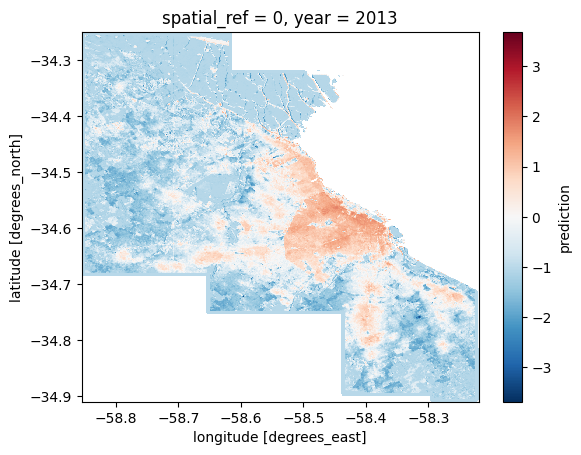

In [14]:
grids[0].prediction.plot()

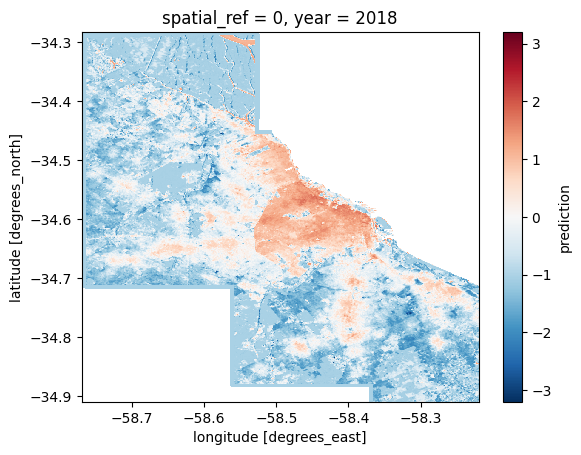

In [13]:
grids[1].prediction.plot()

In [ ]:
import xarray as xr
ds = xr.concat(grids, dim="year")

In [11]:
def plot_raster(grid, black_value=-999, show=True): #

  import folium
  import xarray as xr
  import rioxarray
  import numpy as np
  import matplotlib.pyplot as plt
  from matplotlib.colors import Normalize

  raster_data = grid["prediction_d"]#.isel(year=0)
  original_values = grid["prediction"]
  
  min_x, min_y, max_x, max_y = grids[0].rio.bounds()

  # Step 5: Convert the xarray.DataArray to a numpy array and normalize it
  array = raster_data.values
  array = np.ma.masked_equal(array, np.isnan(array))  # Mask nodata values
  vmin = np.nanmin(array)
  vmax = np.nanmax(array)
  array = np.nan_to_num(array, nan=-999)
  norm = Normalize(vmax=vmax, vmin=vmin)
  norm_array = norm(array)
  norm_array = np.ma.masked_where(array == -999, norm_array)
  norm_array = np.ma.masked_where(original_values == black_value, norm_array) # ground values

  # Step 6: Create a colormap function using Matplotlib
  colormap = plt.cm.Spectral

  # Apply the colormap to the normalized array
  colored_array = colormap(norm_array)

  # Convert the RGBA values to 8-bit integers
  colored_array = (colored_array * 255).astype(np.uint8)

  # Step 6: Create an image overlay
  image = folium.raster_layers.ImageOverlay(
      image=colored_array,
      bounds=[[min_y, min_x], [max_y, max_x]],
      opacity=0.7,
      show=show,
      zindex=20
  )#.add_to(m)

  return image

def load_icpag_dataset(variable="ln_pred_inc_mean", trim=True):
    """Open ICPAG dataset and merge with ELL estimation."""
    path_datain = "G:\Maestría\Tesis\Repo\data\data_in"
    # Open ICPAG dataset
    icpag = gpd.read_file(rf"{path_datain}/ICPAG/base_icpag_500k.shp")
    icpag = icpag.to_crs(epsg=4326)
    icpag = icpag[icpag.AMBA_legal == 1].reset_index(drop=True)
    if trim:
        icpag = icpag[icpag["AREA"] <= 200000]  # Remove rc that are too big
    # Open ELL estimation
    collapse_link = pd.read_stata(rf"{path_datain}/predict_ingreso_collapse.dta")

    # Merge icpag indicators with ELL estimation
    icpag["link"] = icpag["link"].astype(str).str.zfill(9)
    collapse_link["link"] = collapse_link["link"].astype(str).str.zfill(9)
    icpag = icpag.merge(collapse_link, on="link", how="left", validate="1:1")
    icpag["geometry"] = icpag["geometry"].simplify(tolerance=0.0001, preserve_topology=True, )

    # Normalize ELL estimation:
    var_mean = icpag[variable].mean()
    var_std = icpag[variable].std()
    icpag["var"] = (icpag[variable] - var_mean) / var_std

    return icpag


import folium
from folium.plugins import GroupedLayerControl

map_center = (-34.616307, -58.451162)
m = folium.Map(location=map_center, zoom_start=11, control=False, tiles="https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", attr="ArcGIS World Imagery (2024)")

fg1 = folium.FeatureGroup(name='2013')
fg2 = folium.FeatureGroup(name='2018')
fg3 = folium.FeatureGroup(name='2022')
fg4 = folium.FeatureGroup(name='Ninguno')

plot_raster(grids[0], black_value=-1.0264857, show=True).add_to(fg1)
plot_raster(grids[1], black_value=-1.0264857, show=False).add_to(fg2)
plot_raster(grids[2], black_value=-1.0264857, show=False).add_to(fg3)

m.add_child(fg1)
m.add_child(fg2)
m.add_child(fg3)
m.add_child(fg4)

GroupedLayerControl(
    groups={'Predicciones': [fg1, fg2, fg3, fg4]},
    collapsed=True,
).add_to(m)



from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>Abbate (2024). Mapeando el ingreso del AMBA en alta resolución</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
  <div class='legend-title'>Decil del ingreso<br>en base a Censo 2010</div>
    <div class='legend-scale'>
      <ul class='legend-labels'>
        <i style="background: #9e0142; opacity: 0.7; width: 12px; height: 12px; display: inline-block;"></i>  1  <br>
        <i style="background: #d53e4f; opacity: 0.7; width: 12px; height: 12px; display: inline-block;"></i>  2  <br>
        <i style="background: #f46d43; opacity: 0.7; width: 12px; height: 12px; display: inline-block;"></i>  3  <br>
        <i style="background: #fdae61; opacity: 0.7; width: 12px; height: 12px; display: inline-block;"></i>  4  <br>
        <i style="background: #ffffbf; opacity: 0.7; width: 12px; height: 12px; display: inline-block;"></i>  5  <br>
        <i style="background: #e6f598; opacity: 0.7; width: 12px; height: 12px; display: inline-block;"></i>  6  <br>
        <i style="background: #abdda4; opacity: 0.7; width: 12px; height: 12px; display: inline-block;"></i>  7  <br>
        <i style="background: #66c2a5; opacity: 0.7; width: 12px; height: 12px; display: inline-block;"></i>  8  <br>
        <i style="background: #3288bd; opacity: 0.7; width: 12px; height: 12px; display: inline-block;"></i>  9  <br>
        <i style="background: #5e4fa2; opacity: 0.7; width: 12px; height: 12px; display: inline-block;"></i>  10  <br>
      </ul>
    </div>
    <a href="https://doi.org/10.5281/zenodo.13251268"
        style="display: flex; width: 100%; text-align: center; margin-top: 10px; padding: 5px; background-color: #318dbd; color: white; text-decoration: none; border-radius: 4px;">
    Descargar datos
    </a>
</div>
 
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

m.get_root().add_child(macro)


m.save("G:\Maestría\Tesis\ingresoAMBA.github.io\index.html")